In [1]:
from sympy import Max
import os

os.environ["CENSUS_API_KEY"] = '6cf86640c2654b91dfa0418755fae477ccfe0be5'

from epymorph.compartment_model import *

def z_virus_ipm() -> CompartmentModel:
    symbols = create_symbols(
        compartments=[
            compartment('S'),  # 0
            compartment('E'),  # 1
            compartment('I'),  # 2
            compartment('R'),  # 3
            compartment('V'),  # 4
        ],
        attributes=[
            param('beta', shape=Shapes.S, dtype=float),
            param('sigma', shape=Shapes.S, dtype=float),
            param('gamma', shape=Shapes.S, dtype=float),
            param('alpha', shape=Shapes.S, dtype=float),
        ],
    )

    [S, E, I, R, V] = symbols.compartment_symbols
    [beta, sigma, gamma, alpha] = symbols.attribute_symbols

    N = Max(1, S + E + I + R + V)

    return create_model(
        symbols=symbols,
        transitions=[
            edge(S, E, rate=beta * S * I / N),  # 0
            edge(E, I, rate=sigma * E),  # 1
            edge(I, R, rate=gamma * I),  # 2
            edge(S, V, rate=alpha),  # 3
        ]
    )

In [2]:
import numpy as np

from epymorph.data_shape import Shapes
from epymorph.error import GeoValidationException
from epymorph.geo import *
from epymorph.geo.adrio import adrio_maker_library
from epymorph.geo.adrio.census.adrio_census import CensusGeography, Granularity
from epymorph.geo.cache import save_to_cache
from epymorph.geo.dynamic import DynamicGeo

geo_spec = DynamicGeoSpec(
    attributes=[
        AttribDef('label', np.str_, Shapes.N),
        AttribDef('geoid', np.str_, Shapes.N),
        AttribDef('centroid', CentroidDType, Shapes.N),
        AttribDef('population', np.int64, Shapes.N),
        AttribDef('pop_density_km2', np.float64, Shapes.N),
        AttribDef('commuters', np.int64, Shapes.NxN),
    ],
    time_period=Year(2020),
    geography=CensusGeography(
        granularity=Granularity.COUNTY,
        filter={
            'state': ['04', '35', '32', '08', '49'],  # AZ, NM, NV, CO, UT
            'county': ['*'],
            'tract': ['*'],
            'block group': ['*'],
        },
    ),
    source={
        'label': 'Census:name',
        'geoid': 'Census',
        'centroid': 'Census',
        'population': 'Census',
        'pop_density_km2': 'Census',
        'commuters': 'Census',
    },
)

try:
    geo = DynamicGeo.from_library(geo_spec, adrio_maker_library)
    geo.validate()
    save_to_cache(geo, 'devlog-20240214')
except GeoValidationException as e:
    print(e.pretty())

In [3]:
from typing import cast

from epymorph.geo.cache import load_from_cache
from epymorph.geo.static import StaticGeo

g = load_from_cache('devlog-20240214')
my_geo = cast(StaticGeo, load_from_cache('devlog-20240214'))

In [4]:
from functools import partial

import numpy as np

import epymorph.initializer as init
from epymorph import *

sim = StandardSimulation(
    geo=my_geo,
    ipm=z_virus_ipm(),
    mm=mm_library['commuter'](),
    params={
        'alpha': 0,
        'beta': 0.4,
        'sigma': 1 / 3,
        'gamma': 1 / 9,
        'movement_factor': 1,
    },
    time_frame=TimeFrame.of("2020-04-01", 200),
    initializer=partial(init.indexed_locations,
                        selection=np.array([3, 7, 13]), seed_size=100),
)

with sim_messaging(sim):
    out1 = sim.run()

Running simulation (StandardSimulation):
• 2020-04-01 to 2020-10-18 (200 days)
• 158 geo nodes
|####################| 100% 
Runtime: 10.105s


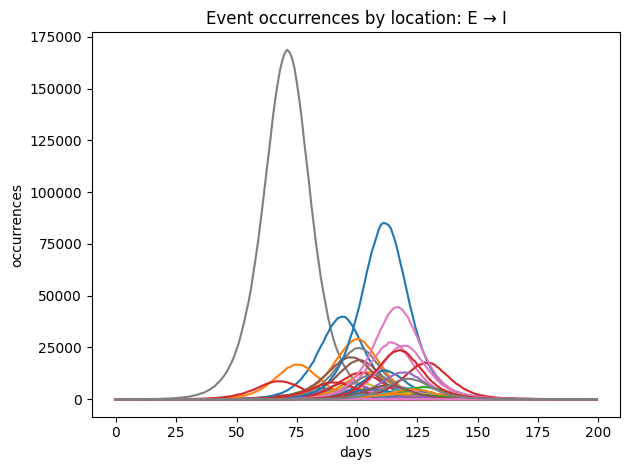

In [6]:
EtoI = 1
plot_event(out1, EtoI)

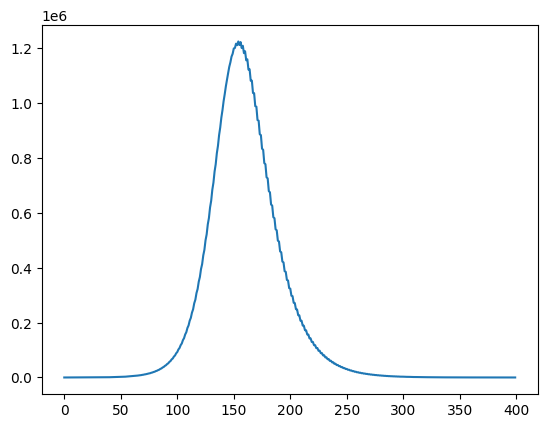

In [14]:
import matplotlib.pyplot as plt
plt.plot(
    np.arange(out1.dim.ticks),
    out1.prevalence[:, 7, 2],
)

plt.show()